In [9]:
#So, this market is looks *very* mean reverting and 
#largely driven by the endogenous risk-free rate, read:Binance Interest Rate.

#Funding rate and quarterly futures are correlated, 
#with what appear to be two or three regimes/clusters. 

#Intuitively, funding rate should lead price down in future periods. 
#For strategy development, considering Boros is market for funding rates...
#will build something that leverages mean reversion via stat arb.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

df = pd.read_csv('../binance_data_pipeline/data/markets/BTCUSDT_1d.csv')
# first futures data in the API was 6/25/23, second month futs come online in the future but NaN until then.
df = df[df["Timestamp"] >= "2023-06-25"]

# make unit for annualized funding match others
df["funding_annualized"] *= 100
df.head()

,Timestamp,spot_open,spot_high,spot_low,spot_close,perp_open,perp_high,perp_low,perp_close,funding_rate,...,prompt_low,prompt_close,prompt_contract,prompt_days_till_expiry,next_open,next_high,next_low,next_close,next_contract,next_days_till_expiry
24,2023-06-25,30527.44,31046.01,30277.49,30462.66,30524.2,31053.2,30252.6,30458.0,0.000100,...,30651.0,30880.3,BTCUSDT_230929,96.333333,NaN,NaN,NaN,NaN,NaN,NaN
25,2023-06-26,30462.67,30666.00,29930.00,30267.99,30458.0,30667.3,29890.1,30260.1,0.000100,...,30340.0,30688.1,BTCUSDT_230929,95.333333,NaN,NaN,NaN,NaN,NaN,NaN
26,2023-06-27,30267.99,30994.97,30226.17,30692.44,30260.1,30998.5,30213.0,30683.2,0.000100,...,30640.1,31201.8,BTCUSDT_230929,94.333333,NaN,NaN,NaN,NaN,NaN,NaN
27,2023-06-28,30692.44,30709.74,29858.80,30077.41,30683.2,30701.8,29804.6,30066.3,0.000080,...,30313.9,30574.8,BTCUSDT_230929,93.333333,NaN,NaN,NaN,NaN,NaN,NaN
28,2023-06-29,30077.40,30843.98,30049.98,30447.31,30066.3,30837.0,30036.1,30439.9,0.000086,...,30522.3,30998.1,BTCUSDT_230929,92.333333,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
# calculate basis and fut apr/apy for prompt
df.rename(columns={"prompt_days_till_expiry": "prompt_dte"}, inplace=True)
df["prompt_basis"] = df["prompt_close"] - df["spot_close"]
df["prompt_apr"] = (df["prompt_basis"] / df["spot_close"]) * (365 / df["prompt_dte"]) * 100
df["prompt_apy"] = (np.exp(df["prompt_apr"] / 100) - 1) * 100

print(df[["Timestamp", "prompt_contract", "prompt_dte",
          "spot_close", "prompt_close", 
          "prompt_basis", "prompt_apr", "prompt_apy"]].head())

     Timestamp prompt_contract  prompt_dte  spot_close  prompt_close  \
24  2023-06-25  BTCUSDT_230929   96.333333    30462.66       30880.3   
25  2023-06-26  BTCUSDT_230929   95.333333    30267.99       30688.1   
26  2023-06-27  BTCUSDT_230929   94.333333    30692.44       31201.8   
27  2023-06-28  BTCUSDT_230929   93.333333    30077.41       30574.8   
28  2023-06-29  BTCUSDT_230929   92.333333    30447.31       30998.1   

    prompt_basis  prompt_apr  prompt_apy  
24        417.64    5.194581    5.331866  
25        420.11    5.314073    5.457805  
26        509.36    6.421273    6.631921  
27        497.39    6.467147    6.680848  
28        550.79    7.151077    7.412972  


In [3]:
# repeat for second fut
# bumping date to prevent NaN in head
df = df[df["Timestamp"] >= "2023-09-29"]

# calculate basis and fut apr/apy for prompt
df.rename(columns={"next_days_till_expiry": "next_dte"}, inplace=True)
df["next_basis"] = df["next_close"] - df["spot_close"]
df["next_apr"] = (df["next_basis"] / df["spot_close"]) * (365 / df["next_dte"]) * 100
df["next_apy"] = (np.exp(df["prompt_apr"] / 100) - 1) * 100

print(df[["Timestamp", "next_contract", "next_dte",
          "spot_close", "next_close", 
          "next_basis", "next_apr", "next_apy"]].head())

      Timestamp   next_contract    next_dte  spot_close  next_close  \
120  2023-09-29  BTCUSDT_240329  182.333333    26906.96     27535.7   
121  2023-09-30  BTCUSDT_240329  181.333333    26962.56     27613.8   
122  2023-10-01  BTCUSDT_240329  180.333333    27992.57     28659.3   
123  2023-10-02  BTCUSDT_240329  179.333333    27494.51     28181.8   
124  2023-10-03  BTCUSDT_240329  178.333333    27426.46     28104.4   

     next_basis  next_apr  next_apy  
120      628.74  4.677710  5.013125  
121      651.24  4.861778  4.900394  
122      666.73  4.820855  5.212652  
123      687.29  5.087751  5.291454  
124      677.94  5.059200  5.478921  


In [4]:
# get the forward rate
df["forward_rate"] = ((df["next_close"] / df["prompt_close"]) - 1) * (365 / (df["next_dte"] - df["prompt_dte"])) * 100

# include binance interest_rate
df["binance_rate"] = 0.0001 * 3 * 365 * 100

print(df[["Timestamp", "prompt_apr", "next_apr", "forward_rate", "funding_annualized", "binance_rate"]].head())

      Timestamp  prompt_apr  next_apr  forward_rate  funding_annualized  \
120  2023-09-29    4.891515  4.677710      4.409153           -2.184525   
121  2023-09-30    4.784108  4.861778      4.881087            1.471680   
122  2023-10-01    5.081337  4.820855      4.509067           -0.944255   
123  2023-10-02    5.156207  5.087751      4.959416            1.854930   
124  2023-10-03    5.334095  5.059200      4.734950            3.043735   

     binance_rate  
120         10.95  
121         10.95  
122         10.95  
123         10.95  
124         10.95  


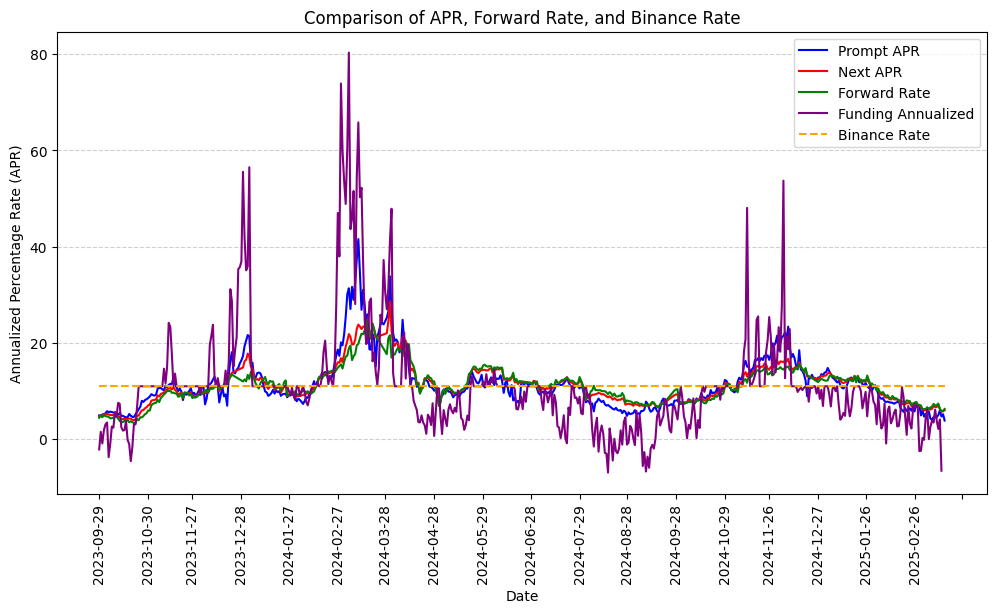

In [5]:
# Set up the figure
plt.figure(figsize=(12, 6))

# Plot all five rates using Seaborn
sns.lineplot(x=df["Timestamp"], y=df["prompt_apr"], color="blue", label="Prompt APR")
sns.lineplot(x=df["Timestamp"], y=df["next_apr"], color="red", label="Next APR")
sns.lineplot(x=df["Timestamp"], y=df["forward_rate"], color="green", label="Forward Rate")
sns.lineplot(x=df["Timestamp"], y=df["funding_annualized"], color="purple", label="Funding Annualized")
sns.lineplot(x=df["Timestamp"], y=df["binance_rate"], color="orange", linestyle="dashed", label="Binance Rate")

# Labels and title
plt.xlabel("Date")
plt.ylabel("Annualized Percentage Rate (APR)")
plt.title("Comparison of APR, Forward Rate, and Binance Rate")
plt.legend()

# Clean up x-axis labels (reduce number of labels)
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Show label every month

# Remove vertical grid lines but keep horizontal ones
plt.grid(axis="y", linestyle="--", alpha=0.6)  # Dashed horizontal grid only

# Show the plot
plt.show()

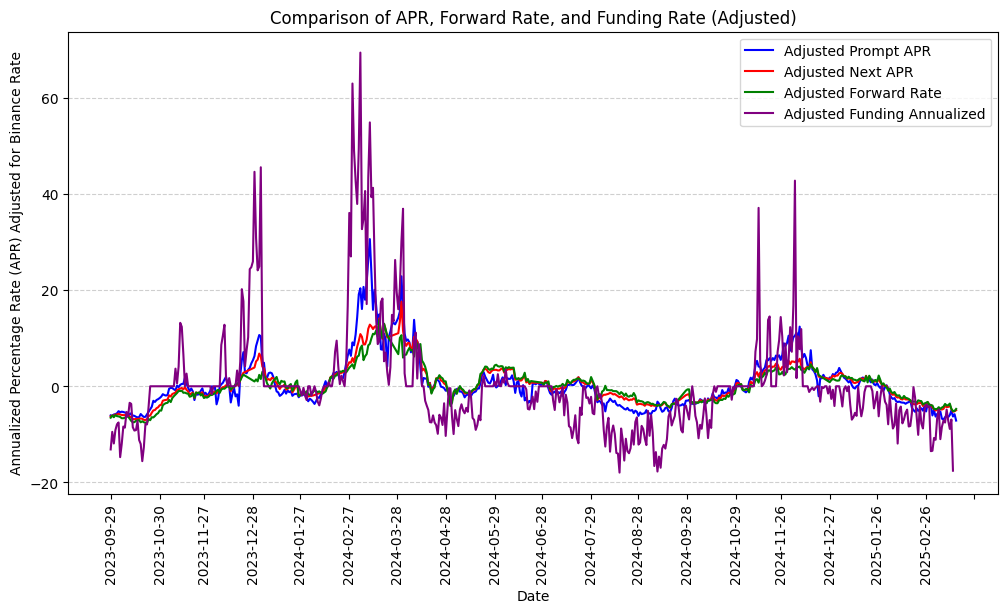

In [6]:
# Subtract Binance rate from the other curves
df["prompt_apr"] -= df["binance_rate"]
df["next_apr"] -= df["binance_rate"]
df["forward_rate"] -= df["binance_rate"]
df["funding_annualized"] -= df["binance_rate"]

# Set up the figure
plt.figure(figsize=(12, 6))

# Plot adjusted rates using Seaborn
sns.lineplot(x=df["Timestamp"], y=df["prompt_apr"], color="blue", label="Adjusted Prompt APR")
sns.lineplot(x=df["Timestamp"], y=df["next_apr"], color="red", label="Adjusted Next APR")
sns.lineplot(x=df["Timestamp"], y=df["forward_rate"], color="green", label="Adjusted Forward Rate")
sns.lineplot(x=df["Timestamp"], y=df["funding_annualized"], color="purple", label="Adjusted Funding Annualized")

# Labels and title
plt.xlabel("Date")
plt.ylabel("Annualized Percentage Rate (APR) Adjusted for Binance Rate")
plt.title("Comparison of APR, Forward Rate, and Funding Rate (Adjusted)")
plt.legend()

# Clean up x-axis labels (reduce number of labels)
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Show label every month

# Remove vertical grid lines but keep horizontal ones
plt.grid(axis="y", linestyle="--", alpha=0.6)  # Dashed horizontal grid only

# Show the plot
plt.show()


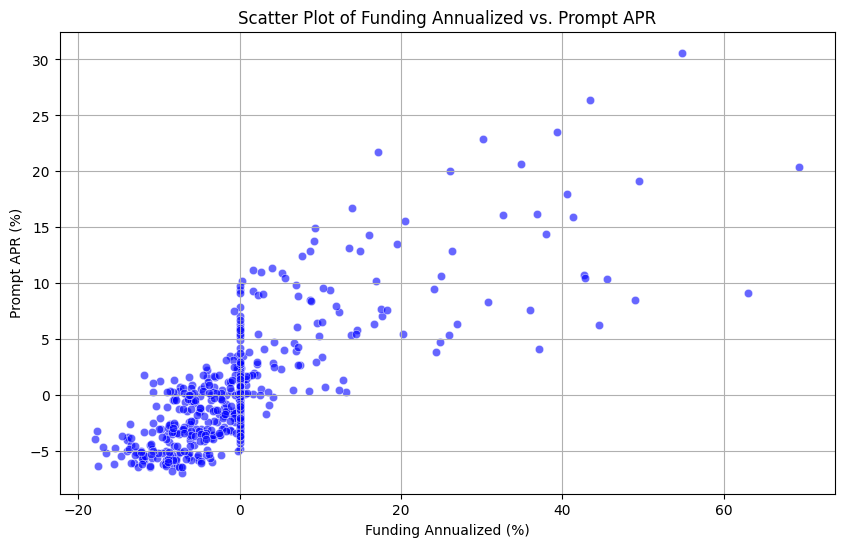

              Condition  Count           Sum
0      Funding < -0.001    261 -1.663234e+03
1  Funding ≈ 0 (±0.001)    159 -2.824407e-13
2       Funding > 0.001    114  1.732650e+03


In [7]:
# Ensure necessary columns exist before plotting
if "funding_annualized" in df.columns and "prompt_apr" in df.columns:
    # Scatter Plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df["funding_annualized"], y=df["prompt_apr"], color="blue", alpha=0.6)
    
    # Labels and title
    plt.xlabel("Funding Annualized (%)")
    plt.ylabel("Prompt APR (%)")
    plt.title("Scatter Plot of Funding Annualized vs. Prompt APR")
    plt.grid(True)
    
    # Show the plot
    plt.show()

# Compute funding condition statistics
funding_negative_count = (df["funding_annualized"] < -0.001).sum()
funding_negative_sum = df.loc[df["funding_annualized"] < -0.001, "funding_annualized"].sum()

funding_zero_count = ((df["funding_annualized"] >= -0.001) & (df["funding_annualized"] <= 0.001)).sum()
funding_zero_sum = df.loc[(df["funding_annualized"] >= -0.001) & (df["funding_annualized"] <= 0.001), "funding_annualized"].sum()

funding_positive_count = (df["funding_annualized"] > 0.001).sum()
funding_positive_sum = df.loc[df["funding_annualized"] > 0.001, "funding_annualized"].sum()

# Create a summary DataFrame
funding_stats = pd.DataFrame({
    "Condition": ["Funding < -0.001", "Funding ≈ 0 (±0.001)", "Funding > 0.001"],
    "Count": [funding_negative_count, funding_zero_count, funding_positive_count],
    "Sum": [funding_negative_sum, funding_zero_sum, funding_positive_sum]
})

# Display statistics
print(funding_stats)

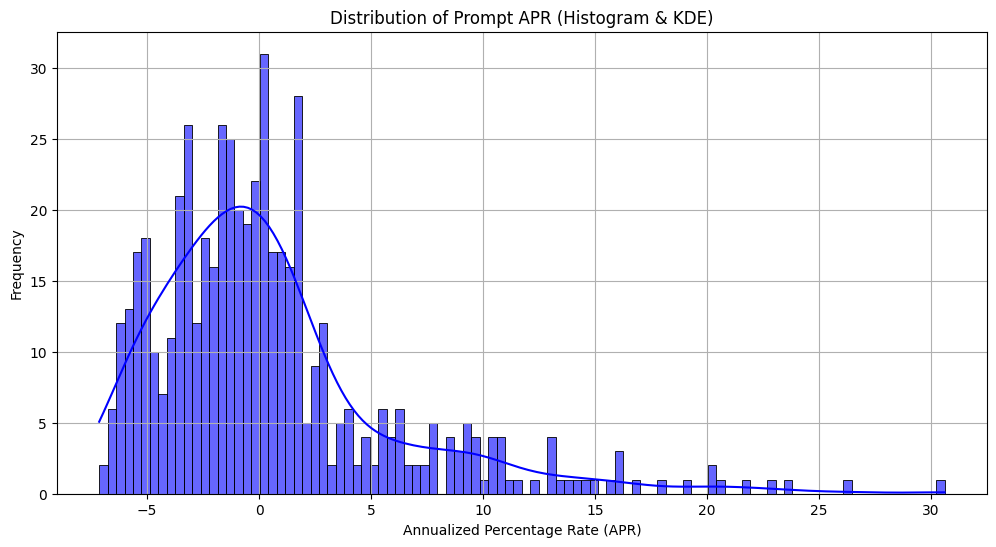

In [8]:

# Set up the figure
plt.figure(figsize=(12, 6))

# Histogram and KDE plot
sns.histplot(df["prompt_apr"], bins=100, kde=True, color="blue", alpha=0.6)

# Labels and title
plt.xlabel("Annualized Percentage Rate (APR)")
plt.ylabel("Frequency")
plt.title("Distribution of Prompt APR (Histogram & KDE)")
plt.grid(True)

# Show the plot
plt.show()
